Reference: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 24.0 MB/s eta 0:00:00


In [ ]:
# Mounting files
import os
import pandas as pd
import random
import evaluate
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Bleu metric
bleu = evaluate.load("google_bleu")

In [ ]:
from torchtext.vocab import GloVe
# It is best to save GloVe data in a cache to reuse across projects.
VECTOR_CACHE_DIR = './.vector_cache'
glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

./.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:46<00:00, 8683.46it/s] 


###**InShorts data**

We use the raw Inshorts dataset which is a .csv file with 55,000+ rows to randomly create pr-dev-small.csv, pr-test-small.csv, pr-train-small.csv. Each csv contains a column for article and a column for summary.

In [ ]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel("/gdrive/MyDrive/datasets/Inshorts_Cleaned_Data.xlsx")

# Keep only 'Headline' and 'Short' columns and discard remaining columns
df = df[['Headline', 'Short']]

# Count the total number of rows in the dataframe
num_rows = len(df)

# Randomly sample 1000 rows without replacement from the dataframe
df_sample = df.sample(n=50000, replace=False)

# Randomly allocate the 1000 rows into 3 different groups with the specified proportions
train_size = 30000
test_size = 10000
dev_size = 10000

train_set = df_sample.sample(n=train_size, replace=False)
df_sample = df_sample.drop(train_set.index)

test_set = df_sample.sample(n=test_size, replace=False)
dev_set = df_sample.drop(test_set.index)

# Export each group to a separate Excel file
train_set.to_excel('/gdrive/MyDrive/datasets/pr-train-small.xlsx', index=False)
test_set.to_excel('/gdrive/MyDrive/datasets/pr-test-small.xlsx', index=False)
dev_set.to_excel('/gdrive/MyDrive/datasets/pr-dev-small.xlsx', index=False)

In [ ]:
data_train = pd.read_excel('/gdrive/MyDrive/datasets/pr-train-small.xlsx')
data_train.head()

,Headline,Short
0,LinkedIn shares drop nearly 30% on weak outlook,Shares of LinkedIn plummeted nearly 30% in aft...
1,Rowling sends Harry Potter ebooks to Syrian girl,"JK Rowling has sent Bana Alabed, a seven-year-..."
2,Chhattisgarh artist helps ex-Maoists find live...,"An artist from Chhattisgarh, Ajay Mandavi, has..."
3,Video mocks need for dongles on new Apple prod...,A YouTube video mocks the need for multiple do...
4,Two Pakistani women go missing in Ahmedabad,"Two Pakistani women, married to two brothers i..."


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower() # lowercase
    # convert have'nt -> have not
    text = text.split()
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    # join entire text after contraction mapping is completed
    text = " ".join(text)
    text = text.split()
    newtext = []
    # create list of words after removing stopwords
    for word in text:
        if word not in stop_words:
            newtext.append(word)
    # create string of same words
    text = " ".join(newtext)
    text = text.replace("'s",'') # convert your's -> your
    text = re.sub(r'\(.*\)','',text) # remove (words inside a parenthesis)
    text = re.sub(r'[^a-zA-Z0-9. ]','',text) # remove punctuations
    text = re.sub(r'\.',' . ',text)
    return text

sample = "(hello) hi there .man tiger caller who's that isn't it ? WALL-E"
print(preprocess(sample))

 hi  . man tiger caller  walle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_train['Headline'] = data_train['Headline'].apply(lambda x:preprocess(x))
data_train['Short'] = data_train['Short'].apply(lambda x:preprocess(x))
print(data_train['Headline'][0],data_train['Short'][0])

linkedin shares drop nearly 30 weak outlook shares linkedin plummeted nearly 30 afterhours trading thursday erasing around 7 billion market capitalisation .  happened professional social networking company reported loss 8 . 4 million december quarter even net revenue grew 34 yearonyear 862 million forecasted weakerthanestimated sales upcoming quarter year . 


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###**Dataloader**

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    '''
    Returns a language object to hold the vocabulary of a language. 
    Attributes:
      name: A string that holds the name of the language.
      word2index: A dictionary that maps a word to its index in the vocabulary.
      word2count: A dictionary that holds the count of each word in the vocabulary.
      index2word: A dictionary that maps an index to its corresponding word in the vocabulary.
      n_words: An integer that holds the total number of unique words in the vocabulary.
    '''
    def __init__(self, name):
      self.name = name
      self.word2index = {}
      self.word2count = {}
      self.index2word = {0: "SOS", 1: "EOS"}
      self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
      '''
      Takes a sentence as an input and adds each word in the sentence to the vocabulary 
      by calling the addWord method for each word in the sentence.
      '''
      for word in sentence.split(' '):
          self.addWord(word)

    def addWord(self, word):
      '''
      Takes a word as an input and adds the word to the vocabulary. 
      If the word is not already in the vocabulary, it creates a new index for 
      the word and adds it to the word2index, word2count, and index2word dictionaries. 
      If the word is already in the vocabulary, it simply updates its count 
      in the word2count dictionary.
      '''
      if word not in self.word2index:
          self.word2index[word] = self.n_words
          self.word2count[word] = 1
          self.index2word[self.n_words] = word
          self.n_words += 1
      else:
          self.word2count[word] += 1

In [ ]:
def readLangs(text, summary, reverse=False):
    print("Reading lines...")
    
    # Split every line into pairs and normalize
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    # Reverse pairs, make Lang instances
    if reverse:
        # if the reverse argument is True, then the pairs list is reversed 
        # using another list comprehension so that the summary lines come first 
        # and the text lines come second.
        pairs = [list(reversed(p)) for p in pairs]
        # instance of the Lang class is created
        input_lang = Lang(summary)
        # instance of the Lang class is created 
        output_lang = Lang(text)
    else:
        input_lang = Lang(text)
        output_lang = Lang(summary)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData(lang1, lang2, reverse=False):

    # instantiate input and output as Lang objects
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    
    # Update vocabulary in input_lang and output_lang objects 
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    # Lang objects have updated vocab for input_lang, output_lang
    return input_lang, output_lang, pairs

In [ ]:
x = data_train['Short']
y = data_train['Headline']
input_lang, output_lang, pairs = prepareData(x, y , False)
print(random.choice(pairs))

Reading lines...
Read 30000 sentence pairs
Counting words...
['editorial peoples daily mouthpiece china39s ruling communist party called great proletarian cultural revolution 34total mistake34 .  editorial said 34we wont never allow mistake like cultural revolution happen again . 34 two million people estimated killed revolution occurred 1966 1976 . ', 'cultural revolution 39total mistake39 china']


To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

###**Model Architecture**

- Encoder Class
- Decoder Class
- Attention Decoder RNN

Seq2Seq network or Encoder Decoder network is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

**Encoder**


With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector. 

For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

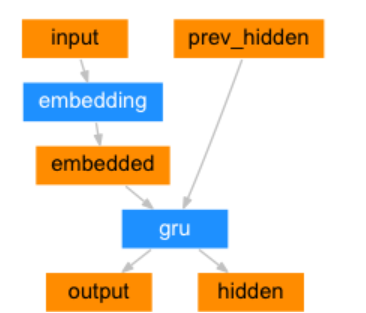

**Decoder**


The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

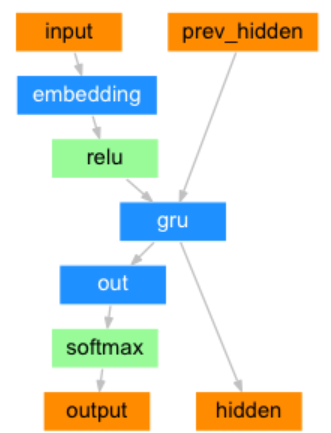


**Attention Decoder**

If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.


Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # initialize embedding - creates a trainable lookup table of input tensor of indices, where each index 
        # corresponds to a row in the embedding table. The output tensor is the 
        # corresponding row from the table for each index in the input tensor. 
        # The embedding table is initialized with random values and is learned during training via backpropagation.
        self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        
        # initialize GRU layer
        # RNNs suffer from vanishing gradient problem which is why they cannot model
        # long term dependencies. GRUs solve this problem by using the update gate 
        # and reset gate. The update gate controls how much information from the 
        # previous time step is passed on to the current time step, and the reset 
        # gate controls how much information is discarded from the previous time step.
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        '''
        GRU takes the input sequence (represented as a sequence of embeddings) 
        and the previous hidden state as input, and computes the output and the 
        new hidden state. Specifically, the input is first passed through a 
        nonlinear transformation, and then the resulting tensor is used to update
        the hidden state. The output is then computed as a linear transformation
        of the hidden state. Finally, the output and the new hidden state are 
        returned as the output of the forward method.
        '''
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        '''
        Initializes the hidden state with zeros. This method is used to initialize
        the hidden state before the first input sequence is processed.
        '''
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    '''
    Takes a hidden state and an input at each time step, and produces an output 
    and an updated hidden state. The decoder RNN is used to generate the headline
    sequence word by word, given the encoded representation of the article.
    '''
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        '''
        It takes an input tensor input of shape (1, 1) and a hidden state tensor 
        hidden of shape (1, 1, hidden_size) as inputs, and returns an output tensor
        of shape (1, output_size) and an updated hidden state tensor of 
        shape (1, 1, hidden_size). The input tensor is first passed through an 
        embedding layer, then a ReLU activation function, and finally the GRU layer.
        The output of the GRU layer is passed through a linear layer and a 
        log softmax activation function to produce the output tensor.
        '''
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        '''
        Initializes the hidden state with zeros. This method is used to initialize
        the hidden state before the first input sequence is processed.
        '''
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
MAX_LENGTH = 90

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        '''
        Initializes an embedding layer, an attention layer, an attention-based 
        combination layer, a dropout layer, a GRU layer, and an output layer.
        '''
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # hidden_size * 2 is because it concatenates the hidden state of the decoder
        # and the context vector (weighted sum of encoder outputs) at each time step,
        # so the input tensor has twice the hidden size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # embedding
        embedded = self.embedding(input).view(1, 1, -1)
        # dropout on embedding
        embedded = self.dropout(embedded)

        # attention weights = concatenating the embedded input and the 
        # current hidden state, and passing the result through the attention 
        # layer followed by a softmax function
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # calculate the context vector by using attention weights and performing
        # a weighted sum of the encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Context vector is concatenated with the embedded input and passed 
        # through the attention-based combination layer.  The resulting tensor 
        # is passed through the GRU layer, and the output is passed through the output layer
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        '''
        Initializes the hidden state with zeros. This method is used to initialize
        the hidden state before the first input sequence is processed.
        '''
        return torch.zeros(1, 1, self.hidden_size, device=device)

### **Training**

To train, we pass the input sentence through the encoder. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.


“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input.


You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

We can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [ ]:
teacher_forcing_ratio = 1
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() # initialize encoder's hidden
    encoder_optimizer.zero_grad() # set encoder gradients as zero
    decoder_optimizer.zero_grad() # set decoder gradients as zero

    # Get the length of this sequence so that the encoder can be run for the
    # appropriate number of time steps for the input and the target 
    # to process the entire sequence
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # store the hidden states of the encoder for each input token in the input sequence
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # initialize training loss
    loss = 0

    # Finally, run the input sequence through encoder and update encoder_ouput
    # and encoder_hidden
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # initialize first input of the decoder when its run for first time
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # initialize hidden state of decoder with hidden state of encoder
    decoder_hidden = encoder_hidden

    # Probability of using teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # Run output through and hidden state through decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # loss = how far the decoder's predicted word is from actual target next word
            loss += criterion(decoder_output, target_tensor[di])
            # Teacher forcing by indexing into the actual target's tensor
            decoder_input = target_tensor[di]  # Teacher forcing
            # ^ decoder_input is recursively passed to decoder() in the subsequent loops

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # decoder_output is a bunch of probabilities for predicting next word
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # The topk(1) function is used to get the most likely token 
            # (with the highest probability) predicted by the decoder at each time step. 
            # This predicted token is then used as the input for the next time step. 
            # If the predicted token is the end-of-sentence token (EOS_token), 
            # the decoding process is stopped.
            topv, topi = decoder_output.topk(1)
            # detach from history as input
            decoder_input = topi.squeeze().detach()  # detach from history as input
            # loss = how far the decoder's predicted word is from actual target next word
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # Backward propagation to minimize the loss
    loss.backward()

    # SGD on decoder and encoder networks applied separately
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Average loss per word in the target sequence
    return loss.item() / target_length

In [ ]:
### UTILITY FUNCTIONs ###
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

1. Start a timer

2. Initialize optimizers and criterion

3. Create set of training pairs

4. Start empty losses array for plotting

Then we call train() function many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss. We then run the train() code for multiple epochs (40).

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.005, n_epochs = 15):
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for t in range(n_epochs):
        # shuffle data inside every epoch
        training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
        print("Epoch: ", t)
        # Iterate through entire training dataset once
        for iter in range(1, n_iters + 1):
            if iter% 1000 == 0:
                print(iter,"/",n_iters + 1)
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)

### **Plotting results**

Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### **Evaluation**


Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    '''
    Same as train() function above^, except there are no targets so we simply 
    feed the decoder’s predictions back to itself for each step
    '''
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    '''
    Evaluate random sentences from the training set and print out the input, 
    target, and output to make some subjective quality judgements
    '''
    total_bleu_score = 0
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        total_bleu_score = total_bleu_score + bleu.compute(predictions=[output_sentence], references=[pair[1]])['google_bleu']
    avg_bleu_score = total_bleu_score/100
    print("Average Bleu score: ", avg_bleu_score)    

In [ ]:
hidden_size = 300
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.5).to(device)

trainIters(encoder1, attn_decoder1, 6000, print_every=100)

Training....
Epoch:  0
0m 7s (- 7m 1s) (100 1%) 10.0443
0m 11s (- 5m 42s) (200 3%) 10.0433
0m 16s (- 5m 9s) (300 5%) 10.2201
0m 21s (- 5m 5s) (400 6%) 10.0709
0m 26s (- 4m 49s) (500 8%) 10.6812
0m 30s (- 4m 37s) (600 10%) 10.6433
0m 36s (- 4m 33s) (700 11%) 10.2634
0m 40s (- 4m 23s) (800 13%) 10.3176
0m 45s (- 4m 15s) (900 15%) 10.1268
1000 / 6001
0m 50s (- 4m 12s) (1000 16%) 10.3517
0m 54s (- 4m 4s) (1100 18%) 10.3756
0m 59s (- 3m 58s) (1200 20%) 10.9807
1m 4s (- 3m 53s) (1300 21%) 10.3503
1m 9s (- 3m 47s) (1400 23%) 10.6254
1m 14s (- 3m 43s) (1500 25%) 10.6360
1m 19s (- 3m 37s) (1600 26%) 10.4468
1m 23s (- 3m 31s) (1700 28%) 10.5148
1m 29s (- 3m 28s) (1800 30%) 10.5114
1m 33s (- 3m 22s) (1900 31%) 10.3588
2000 / 6001
1m 38s (- 3m 16s) (2000 33%) 10.5175
1m 43s (- 3m 12s) (2100 35%) 10.4187
1m 47s (- 3m 6s) (2200 36%) 10.5290
1m 52s (- 3m 0s) (2300 38%) 10.4458
1m 57s (- 2m 56s) (2400 40%) 10.4047
2m 2s (- 2m 51s) (2500 41%) 10.3804
2m 6s (- 2m 45s) (2600 43%) 10.5321
2m 12s (- 2m 41s

KeyboardInterrupt: ignored

In [ ]:
torch.save(encoder1.state_dict(), './enc.w')
torch.save(attn_decoder1.state_dict(), './att.w')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1, pairs)

> automobile major nissan india launched new micra hatchback new sunshine orange colour europeanstyle allblack sporty interior ahead festive season .  car starting price 4 . 55 lakh  . 
= nissan launches new micra europeanstyle interiors
< soon celebrity celebrity <EOS>

> pm narendra modi currently fiveday tour africa signed four pacts friday south african president jacob zuma .  agreements linked fields information communications technology tourism arts culture science technology .  pm modi also sought deeper collaboration south africa defence sector . 
= pm modi signs four pacts south africa
< blue catches pm modi catches catches pm modi london london pm modi catches <EOS>

> paying tribute security personnel lost lives encounters terrorists jammu kashmir army chief general bipin rawat said locals display flags isis pakistan treated antinationals .  said disrupt army operations supportive treated 34overground workers terrorists34 . 
= mob pak flags seen antinational army chief
< wor

In [ ]:
data_dev = pd.read_excel('/gdrive/MyDrive/datasets/pr-dev-small.xlsx')
dev_x = data_dev['Short']
dev_y = data_dev['Headline']
_, _, dev_pairs = prepareData(x, y , False)
evaluateRandomly(encoder1, attn_decoder1, dev_pairs)

Reading lines...
Read 30000 sentence pairs
Counting words...
> rbi wednesday gave inprinciple approval common service centres  rural areas collect payments services like electricity water gas .  facility rolled within around three months union minister ravi shankar prasad said .  cscs physical facilities meant delivery eservices government rural remote locations . 
= rbi approves common rural bill payment centres
< schools schools schools hire last <EOS>

> former argentinian dictator reynaldo bignone  sentenced 20 years imprisonment conspiring assassinate leftist dissidents part operation condor 1970s 1980s .  fourteen exmilitary officials also jailed operation coordinated dictatorships numerous nations .  estimates claim least 60000 people killed . 
= former argentine dictator jailed 20 years
< nokia pvt schools compares compares compares compares compares edge <EOS>

> many 3400 personnel paramilitary forces delhi police along quick reaction teams deployed across national capital ma

In [ ]:
data_test = pd.read_excel('/gdrive/MyDrive/datasets/pr-test-small.xlsx')
test_x = data_test['Short']
test_y = data_test['Headline']
_, _, test_pairs = prepareData(x, y , False)
evaluateRandomly(encoder1, attn_decoder1, test_pairs)

Reading lines...
Read 30000 sentence pairs
Counting words...
> scientists identified new fossilized reptile lived around 250 million years ago .  specimen discovered last year brazil .  discovery found small quadrupedal animal grew 1 . 5 metres length .  discovery may help understanding origins dinosaurs flying reptiles crocodiles researchers said . 
= scientists discover 250 mnyrold reptile fossil
< rare 24 24 <EOS>

> extensive research its found river saraswati exist india ancient times got buried due tectonic changes himalayas claimed scientists dehradunbased wadia institute himalayan geology .  river flowed origin shivalik range haryana meeting point chautang river plains added . 
= river saraswati exist ancient times scientists
< nokia nokia nokia <EOS>

> jawaharlal nehru university  news since february 9 due sedition controversy two three visitors awards instituted president pranab mukherjee last year .  jnu received awards innovation research categories tezpur university assam